Krzysztof Sołowiej

krsolowiej@gmail.com

# Training, testing and using image segmentation model with TensorFlow

Coco style annotations in JSON format

In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from matplotlib import pyplot as plt

In [2]:
from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config

In [3]:
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [4]:
from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw

# Dataset preparation

In [5]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids


In [6]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/train/train.json', 'C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/train')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/test/test.json', 'C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/test')
dataset_val.prepare()

In [7]:
dataset = dataset_train
image_ids = dataset.image_ids
image_ids = np.random.choice(dataset.image_ids, 3)
#for image_id in image_ids:
#    image = dataset.load_image(image_id)
#    mask, class_ids = dataset.load_mask(image_id)
#    display_top_masks(image, mask, class_ids, dataset.class_names, limit=2)

# Showing single image with annotations

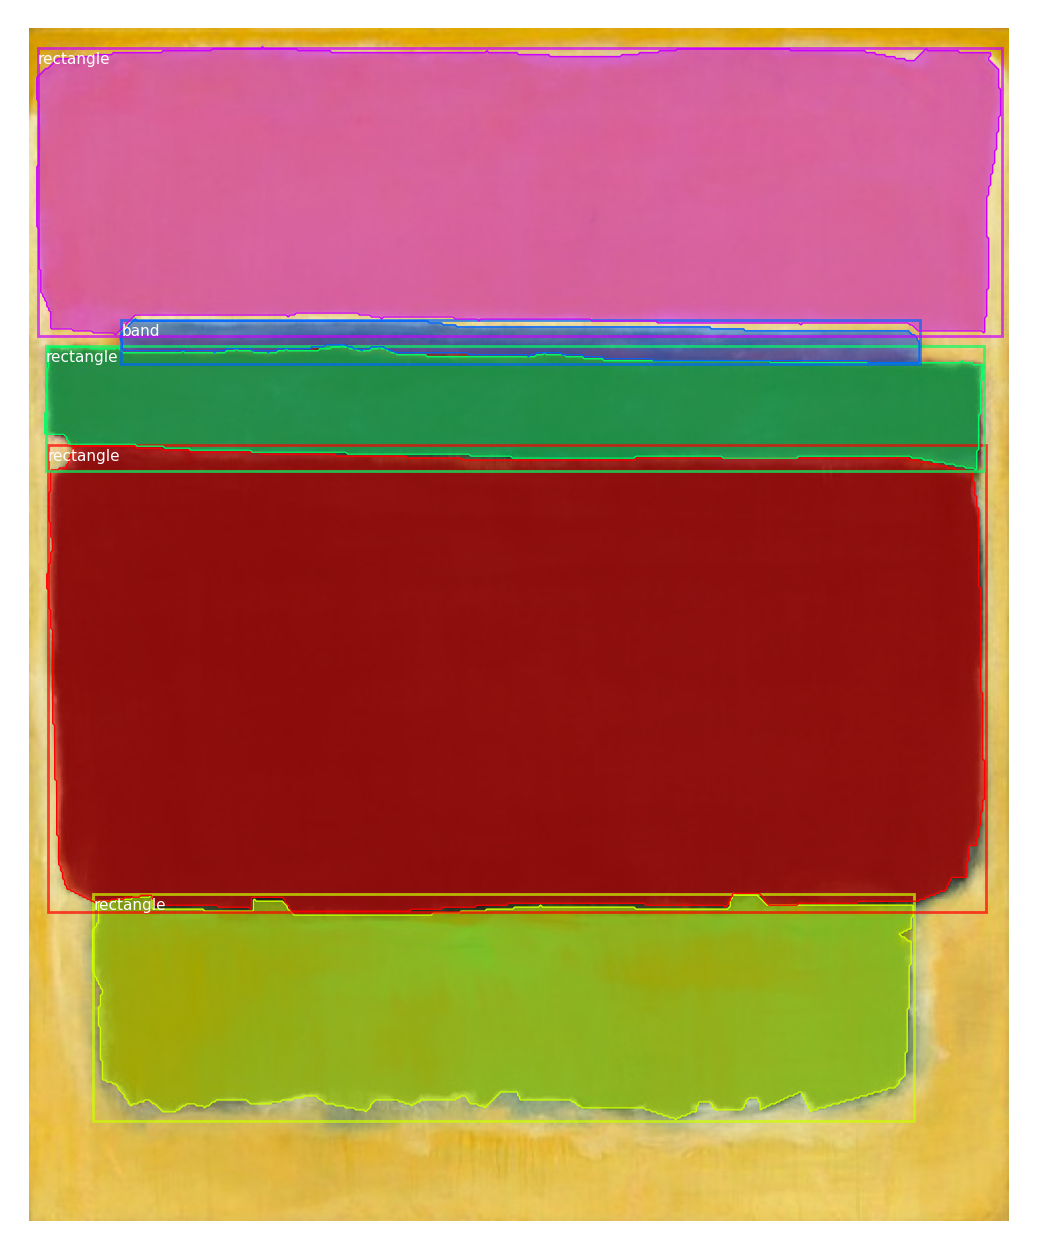

In [8]:
# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

# Training

In [9]:
# define a configuration for the model
class RothkoConfig(Config):
	# define the name of the configuration
	NAME = "rothko_cfg_coco"
	# number of classes (background + class 1 + class 2)
	NUM_CLASSES = 1 + 2
	# number of training steps per epoch
	STEPS_PER_EPOCH = 128
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# prepare config
config = RothkoConfig()
config.display() 


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [10]:
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [11]:
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# For training uncomment the following line
#model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')

# Testing trained model

In [12]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle


# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "rothko_cfg_coco"
	# number of classes (background + 2 classes)
	NUM_CLASSES = 1 + 2
	# Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
 

In [13]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the Mean Average Precision across all images
	mAP = mean(APs)
	return mAP
 

In [14]:
# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)

# load model weights
model.load_weights('C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/logs/mask_rcnn_rothko_cfg_coco_0007.h5', by_name=True)

# evaluate model on training dataset
#train_mAP = evaluate_model(dataset_train, model, cfg)
#print("Train mAP (Mean Average Precision): %.3f" % train_mAP)

# evaluate model on test dataset
test_mAP = evaluate_model(dataset_train, model, cfg)
print("Test mAP (Mean Average Precision): %.3f" % test_mAP)

Test mAP (Mean Average Precision): 0.805


# Using trained model

Number of detected shapes: 3
Detection score threshold:  0.94
Number of displayed shapes above set threshold: 3


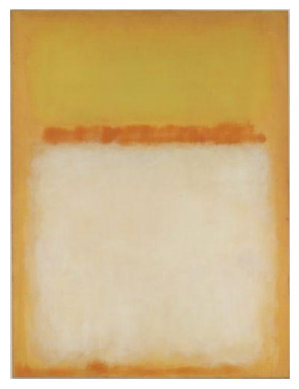

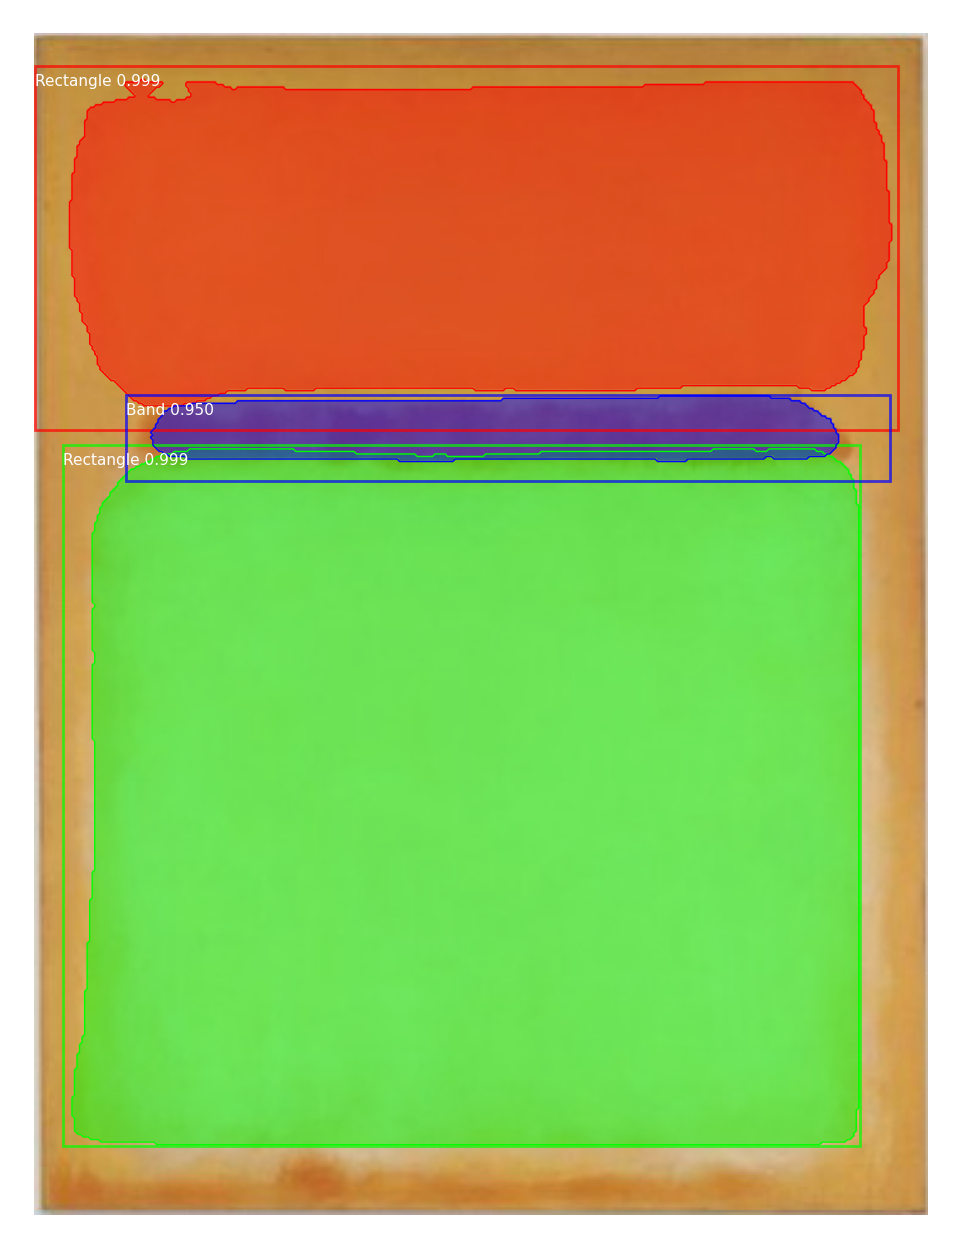

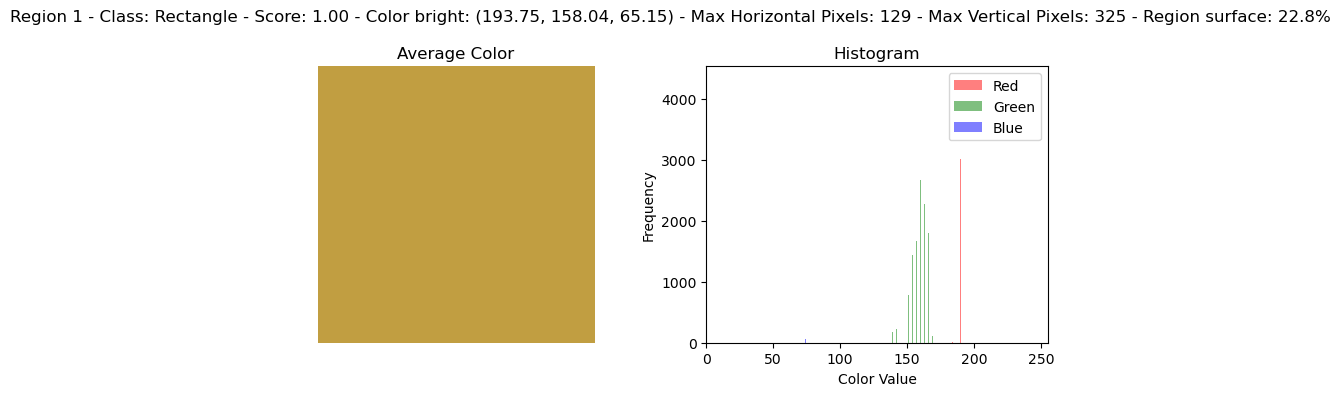

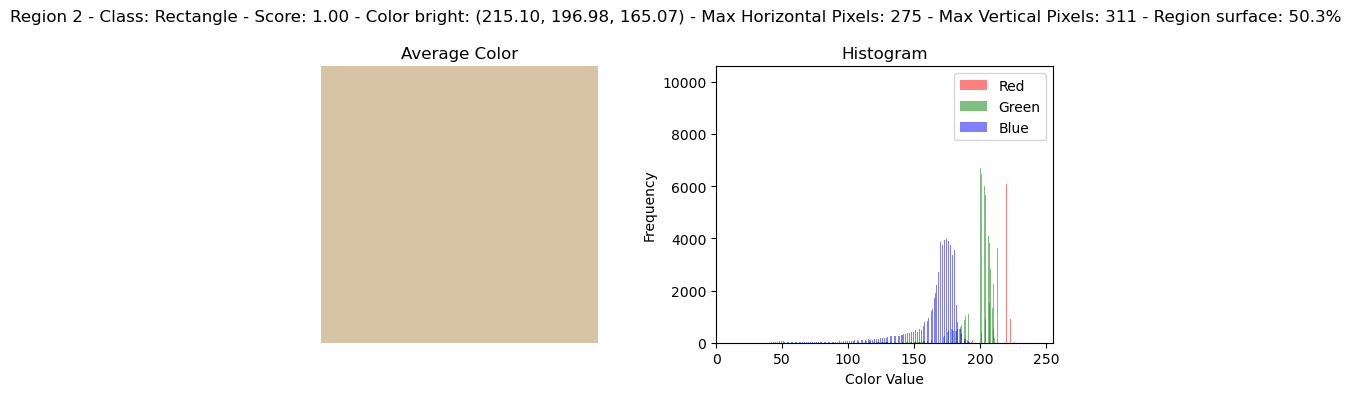

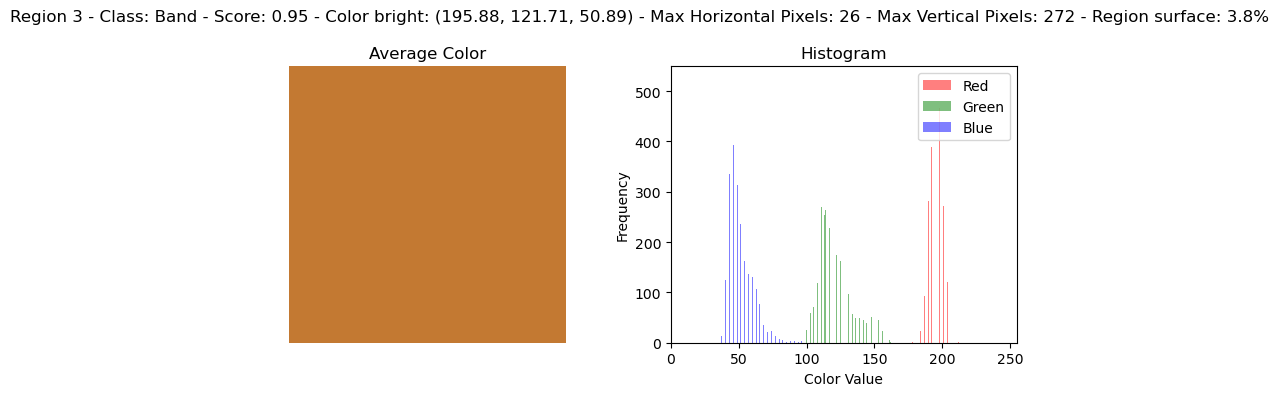

In [20]:
sample_img = skimage.io.imread("C:/Users/ks/Desktop/IT/ds_projects/Mask-RCNN-TF2-master/rothko/sample/10.png")
plt.imshow(sample_img)
plt.axis('off')

# Detect objects in the image
detected = model.detect([sample_img])
results = detected[0]

# Get the number of detected shapes
num_shapes = len(results['class_ids'])
print("Number of detected shapes:", num_shapes)

# Set the threshold for displayed objects and color analysis
threshold = 0.94
print('Detection score threshold: ', threshold)

# Get the indices of objects with scores greater than or equal to the threshold
idxs = np.where(results['scores'] >= threshold)[0]

# Extract the relevant results for the displayed objects
rois = results['rois'][idxs]
masks = results['masks'][:,:,idxs]
class_ids = results['class_ids'][idxs]
scores = results['scores'][idxs]

# Count the number of displayed shapes
num_displayed_shapes = len(class_ids)
print("Number of displayed shapes above set threshold:", num_displayed_shapes)

# Calculate the total number of pixels in the image
total_pixels = sample_img.shape[0] * sample_img.shape[1]

# Display the image with the detected shapes
class_names = ['BG', 'Rectangle', 'Band']
display_instances(sample_img, rois, masks, class_ids, class_names, scores)

# Get the indices of objects with scores greater than or equal to the threshold
idxs = np.where(results['scores'] >= threshold)[0]

# Extract the relevant masks for the displayed objects
masks = results.get('masks')[:,:,idxs]

# Define a function to check if a color is bright or dull
def is_bright(rgb):
    brightness = np.sqrt(np.dot(rgb, rgb))
    return brightness > 128

# Extract the pixels and colors of the displayed regions
region_pixels = []
region_colors = []
for i in range(masks.shape[2]):
    mask = masks[:,:,i]
    pixels = sample_img[mask]
    colors = np.mean(pixels, axis=0)
    height, width = mask.shape
    region_pixels.append(pixels)
    region_colors.append(colors)
    
    # Calculate the maximum horizontal and vertical pixels
    max_horizontal_pixels = np.max(np.sum(mask, axis=0))
    max_vertical_pixels = np.max(np.sum(mask, axis=1))
    
    # Calculate the percentage surface of the region in relation to the whole image
    region_surface = np.round((np.sum(mask) / total_pixels * 100), 1)
    
    # Loop over each region to display its color information
    for i in range(len(region_colors)):
        rgb = region_colors[i]
    if is_bright(rgb):
        brightness = "bright"
    else:
        brightness = "dull"

    # Create a figure with subplots for the color rectangle and histogram
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

    # Add the color rectangle subplot
    color_rect = np.array([colors])
    axs[0].imshow(color_rect.reshape(1, 1, 3)/255.0)
    axs[0].set_title('Average Color')
    axs[0].axis('off')

    # Add the histogram subplot
    axs[1].hist(pixels[:, 0], bins=256, color='Red', alpha=0.5, label='Red')
    axs[1].hist(pixels[:, 1], bins=256, color='Green', alpha=0.5, label='Green')
    axs[1].hist(pixels[:, 2], bins=256, color='Blue', alpha=0.5, label='Blue')
    axs[1].legend(loc='upper right')
    axs[1].set_xlim([0, 255])
    axs[1].set_xlabel('Color Value')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram')
    plt.suptitle('Region {} - Class: {} - Score: {:.2f} - Color {}: ({:.2f}, {:.2f}, {:.2f}) - Max Horizontal Pixels: {} - Max Vertical Pixels: {} - Region surface: {}%'.format(
                i+1, class_names[results.get('class_ids')[idxs[i]]], results.get('scores')[idxs[i]], brightness,
                region_colors[i][0], region_colors[i][1], region_colors[i][2], 
                max_horizontal_pixels, max_vertical_pixels, region_surface))

    plt.show()
